## Coursera Applied Data Science Capstone Course by IBM

### Capstone Project: Exploring Neighborhoods Around Subway Stations With Largest Ridership Drops During the COVID-19 Pandemic
### April 19, 2020

### Introduction

New York City is the epicenter of the coronavirus pandemic in the United States. As the number of Covid-19 cases grew in NYC throughout March 2020, subway ridership plunged as businesses implemented remote working policies, and non-essential businesses closed. In this project, I utilized the subway ridership data from the NYC Metropolitan Transportation Authority (“MTA”) along with the Foursquare API to identify what kind of venues are most common near the subway stations that showed the greatest drop in ridership in March. <br><br> Based on the results, we can infer what type of venues would have experienced the largest drop in the number of customers/visitors. This analysis can be used by the New York State and New York City governments in planning support programs for businesses hardest hit by the pandemic.

### Data

For this project, we will need data for the following data:
- Subway ridership data to indentify the subway stations with the largest ridership drops in March
- Geographical coordinates of the selected subway stations
- FourSquare data to identify the most popular venues around the selected subway stations

In [1]:
# Import libraries

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from sklearn.cluster import KMeans

print('Libraries Imported.')

%autosave 180

Libraries Imported.


Autosaving every 180 seconds


#### Subway Ridership Data

First, I will utilize the subway turnstile data from the MTA, available at http://web.mta.info/developers/turnstile.html. This dataset includes the cumulative number of entries and exits for each NYC subway station control area at various points in time, normally every four hours. Each subway station has one or multiple control areas (shown in column ‘C/A’), one or multiple remote units (in column ‘UNIT’), and one or multiple devices (in column ‘SCP’, short for Subunit Channel Position, which is a specific address for a device). 

In [41]:
# Read the weekly data from the MTA website

mar7 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_200307.txt')
mar14 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_200314.txt')
mar21 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_200321.txt')
mar28 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_200328.txt')
apr4 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_200404.txt')


mar_df = mar7.append(mar14).append(mar21).append(mar28).append(apr4)

print('Dataframe Ready.')

Dataframe Ready.


In [42]:
print('The dataset covers from ', mar_df['DATE'].min(), 'to', mar_df['DATE'].max())

station_list = mar_df['STATION'].unique()

print('Number of stations:',len(station_list))

The dataset covers from  02/29/2020 to 04/03/2020
Number of stations: 378


In [43]:
# Let's check what the data for the 14th St-Union Square station looks like on March 1, 2020

mar_df[(mar_df['STATION']=='14 ST-UNION SQ') & (mar_df['DATE']=='03/01/2020')]

C/A  UNIT       SCP         STATION  LINENAME DIVISION        DATE  \
4709    A033  R170  02-00-00  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4710    A033  R170  02-00-00  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4711    A033  R170  02-00-00  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4712    A033  R170  02-00-00  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4713    A033  R170  02-00-00  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4714    A033  R170  02-00-00  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4751    A033  R170  02-00-01  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4752    A033  R170  02-00-01  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4753    A033  R170  02-00-01  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4754    A033  R170  02-00-01  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4755    A033  R170  02-00-01  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4756    A033  R170  02-00-01  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4793    A033  R170  02-00-02  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4794    A033  R170  02-00-02  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4795    A033  R170  02-00-02  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4796    A033  R170  02-00-02  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4797    A033  R170  02-00-02  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4798    A033  R170  02-00-02  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4835    A033  R170  02-00-03  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4836    A033  R170  02-00-03  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4837    A033  R170  02-00-03  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4838    A033  R170  02-00-03  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4839    A033  R170  02-00-03  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4840    A033  R170  02-00-03  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4877    A033  R170  02-00-04  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4878    A033  R170  02-00-04  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4879    A033  R170  02-00-04  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4880    A033  R170  02-00-04  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4881    A033  R170  02-00-04  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4882    A033  R170  02-00-04  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4919    A033  R170  02-00-05  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4920    A033  R170  02-00-05  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4921    A033  R170  02-00-05  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4922    A033  R170  02-00-05  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4923    A033  R170  02-00-05  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4924    A033  R170  02-00-05  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4961    A033  R170  02-06-00  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4962    A033  R170  02-06-00  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4963    A033  R170  02-06-00  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4964    A033  R170  02-06-00  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4965    A033  R170  02-06-00  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
4966    A033  R170  02-06-00  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
5003    A033  R170  02-06-01  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
5004    A033  R170  02-06-01  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
5005    A033  R170  02-06-01  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
5006    A033  R170  02-06-01  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
5007    A033  R170  02-06-01  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
5008    A033  R170  02-06-01  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
5045    A034  R170  03-00-00  14 ST-UNION SQ  LNQR456W      BMT  03/01/2020   
5046    A034  R170  03-00-00  14 ST-UNION SQ  LNQR456W     

Here are the descriptions of the columns provided by the MTA obtained from http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt.

C/A      = Control Area (A002)<br>
UNIT     = Remote Unit for a station (R051)<br>
SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)<br>
STATION  = Represents the station name the device is located at<br>
LINENAME = Represents all train lines that can be boarded at this station<br>
           Normally lines are represented by one character.  LINENAME 456NQR represents train server for 4, 5, 6, N, Q, and R trains.<br>
DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND <br>  
DATE     = Represents the date (MM-DD-YY)<br>
TIME     = Represents the time (hh:mm:ss) for a scheduled audit event<br>
DESC     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)<br>
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities.
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered.
ENTRIES  = The comulative entry register value for a device<br>
EXITS    = The cumulative exit register value for a device<br>

In [44]:
# Analyze the station control area, remote unit and device combinations
# I downloaded the remote unit, control area, station name key from http://web.mta.info/developers/turnstile.html
remote_booth_station = pd.read_excel('Remote-Booth-Station.xls')

# We can see that the booths are unique.
print(len(remote_booth_station))
print(len(remote_booth_station['Booth'].unique()))

# We can see that these booths are equivalent to the control areas in the turnstile dataset.
remote_booth_station[remote_booth_station['Station'] == '14 ST-UNION SQ']

768
768


Remote Booth         Station Line Name Division
313   R170  A035  14 ST-UNION SQ   LNQR456      BMT
314   R170  R221  14 ST-UNION SQ   LNQR456      IRT
315   R170  A033  14 ST-UNION SQ   456LNQR      BMT
316   R170  A034  14 ST-UNION SQ   LNQR456      BMT
317   R170  A036  14 ST-UNION SQ   LNQR456      BMT
318   R170  A037  14 ST-UNION SQ   LNRQ456      BMT

We need to convert the data from the cumulative number of entry register values to the daily number of entries for each station.

In [45]:
# Create a copy of the dataframe
all_stations_df = mar_df

# Create column that is combination of control area, remote unit and device address for the station
all_stations_df['STATION-C/A-SCP'] = all_stations_df[['STATION', 'C/A', 'SCP']].agg('-'.join, axis=1)

# Minimum number of cumulative entry regsiter value for the device for each day
min_entries = all_stations_df.groupby(['STATION-C/A-SCP','DATE'])['ENTRIES'].min()

min_entries = min_entries.reset_index()

# Change the dataframe from long to wide
min_entries_wide = min_entries.pivot(index='DATE', columns='STATION-C/A-SCP', values='ENTRIES')

min_entries_wide.head()

STATION-C/A-SCP  1 AV-H007-00-00-00  1 AV-H007A-02-00-00  1 AV-H007A-02-00-01  \
DATE                                                                            
02/29/2020               15455022.0              42656.0              33449.0   
03/01/2020               15455022.0              44769.0              34990.0   
03/02/2020               15455022.0              46232.0              35975.0   
03/03/2020               15455022.0              49262.0              37896.0   
03/04/2020               15455022.0              52531.0              39997.0   

STATION-C/A-SCP  1 AV-H007A-02-00-02  1 AV-H007A-02-00-03  \
DATE                                                        
02/29/2020                   23403.0              17476.0   
03/01/2020                   24643.0              18395.0   
03/02/2020                   25447.0              19003.0   
03/03/2020                   26794.0              20109.0   
03/04/2020                   28352.0              21329.0   

STATION-C/A-SCP  1 AV-H007A-02-00-04  1 AV-H007A-02-03-00  \
DATE                                                        
02/29/2020                   19865.0               9816.0   
03/01/2020                   20780.0               9816.0   
03/02/2020                   21404.0               9817.0   
03/03/2020                   22928.0               9982.0   
03/04/2020                   24550.0              10138.0   

STATION-C/A-SCP  1 AV-H007A-02-03-01  1 AV-H007A-02-03-02  \
DATE                                                        
02/29/2020                   37569.0              78551.0   
03/01/2020                   37570.0              78554.0   
03/02/2020                   37570.0              78554.0   
03/03/2020                   38166.0              79692.0   
03/04/2020                   38708.0              80764.0   

STATION-C/A-SCP  1 AV-H007A-02-03-03  1 AV-H007A-02-03-04  \
DATE                                                        
02/29/2020                  119613.0             195458.0   
03/01/2020                  119619.0             195463.0   
03/02/2020                  119622.0             195465.0   
03/03/2020                  121347.0             198115.0   
03/04/2020                  122963.0             200819.0   

STATION-C/A-SCP  103 ST-CORONA-R529-00-00-00  103 ST-CORONA-R529-00-00-01  \
DATE                                                                        
02/29/2020                        16065908.0                   14769070.0   
03/01/2020                        16067092.0                   14770095.0   
03/02/2020                        16068046.0                   14770859.0   
03/03/2020                        16069901.0                   14772507.0   
03/04/2020                        16071974.0                   14774331.0   

STATION-C/A-SCP  103 ST-CORONA-R529-00-00-02  103 ST-CORONA-R529-00-00-03  \
DATE                                                                        
02/29/2020                         2743647.0                    1804505.0   
03/01/2020                         2744909.0                    1806365.0   
03/02/2020                         2745741.0                    1807657.0   
03/03/2020                         2747399.0                    1809998.0   
03/04/2020                         2749253.0                    1812470.0   

STATION-C/A-SCP  103 ST-CORONA-R529-00-00-04  103 ST-CORONA-R529-00-05-00  \
DATE                                                                        
02/29/2020                         6582268.0                   13340087.0   
03/01/2020                         6584837.0                   13342500.0   
03/02/2020                         6586836.0                   13344363.0   
03/03/2020                         6590365.0                   13347808.0   
03/04/2020                         6593618.0                   13351217.0   

STATION-C/A-SCP  103 ST-CORONA-R529-00-05-01  103 ST-CORONA-R529-00-06-00  \
DATE                   

In [46]:
# Calculate the daily number of entries
# The number of daily entries is the difference between the minimum cumulative entry register value for the next day
# minus the number of minimum cumulative entry register value for the day
daily_entries = min_entries_wide.diff()
daily_entries = daily_entries.shift(-1)

# Drop rows that are all NAs
daily_entries = daily_entries.dropna(axis=0,how='all')

daily_entries.head()

STATION-C/A-SCP  1 AV-H007-00-00-00  1 AV-H007A-02-00-00  1 AV-H007A-02-00-01  \
DATE                                                                            
02/29/2020                      0.0               2113.0               1541.0   
03/01/2020                      0.0               1463.0                985.0   
03/02/2020                      0.0               3030.0               1921.0   
03/03/2020                      0.0               3269.0               2101.0   
03/04/2020                      0.0               3051.0               1863.0   

STATION-C/A-SCP  1 AV-H007A-02-00-02  1 AV-H007A-02-00-03  \
DATE                                                        
02/29/2020                    1240.0                919.0   
03/01/2020                     804.0                608.0   
03/02/2020                    1347.0               1106.0   
03/03/2020                    1558.0               1220.0   
03/04/2020                    1384.0               1084.0   

STATION-C/A-SCP  1 AV-H007A-02-00-04  1 AV-H007A-02-03-00  \
DATE                                                        
02/29/2020                     915.0                  0.0   
03/01/2020                     624.0                  1.0   
03/02/2020                    1524.0                165.0   
03/03/2020                    1622.0                156.0   
03/04/2020                    1481.0                122.0   

STATION-C/A-SCP  1 AV-H007A-02-03-01  1 AV-H007A-02-03-02  \
DATE                                                        
02/29/2020                       1.0                  3.0   
03/01/2020                       0.0                  0.0   
03/02/2020                     596.0               1138.0   
03/03/2020                     542.0               1072.0   
03/04/2020                     524.0               1092.0   

STATION-C/A-SCP  1 AV-H007A-02-03-03  1 AV-H007A-02-03-04  \
DATE                                                        
02/29/2020                       6.0                  5.0   
03/01/2020                       3.0                  2.0   
03/02/2020                    1725.0               2650.0   
03/03/2020                    1616.0               2704.0   
03/04/2020                    1584.0               2514.0   

STATION-C/A-SCP  103 ST-CORONA-R529-00-00-00  103 ST-CORONA-R529-00-00-01  \
DATE                                                                        
02/29/2020                            1184.0                       1025.0   
03/01/2020                             954.0                        764.0   
03/02/2020                            1855.0                       1648.0   
03/03/2020                            2073.0                       1824.0   
03/04/2020                            2153.0                       1854.0   

STATION-C/A-SCP  103 ST-CORONA-R529-00-00-02  103 ST-CORONA-R529-00-00-03  \
DATE                                                                        
02/29/2020                            1262.0                       1860.0   
03/01/2020                             832.0                       1292.0   
03/02/2020                            1658.0                       2341.0   
03/03/2020                            1854.0                       2472.0   
03/04/2020                            1993.0                       2658.0   

STATION-C/A-SCP  103 ST-CORONA-R529-00-00-04  103 ST-CORONA-R529-00-05-00  \
DATE                                                                        
02/29/2020                            2569.0                       2413.0   
03/01/2020                            1999.0                       1863.0   
03/02/2020                            3529.0                       3445.0   
03/03/2020                            3253.0                       3409.0   
03/04/2020                            3751.0                       3194.0   

STATION-C/A-SCP  103 ST-CORONA-R529-00-05-01  103 ST-CORONA-R529-00-06-00  \
DATE                   

In [47]:
# As we see in the dataframe above, some of the devices sometimes return negative or very large daily count of entries.
# Identify units that has either negative entries or very large entries

# Boolean dataframes
negative_entries = daily_entries.le(-1)
too_large_entries = daily_entries.ge(100000)

negative_entry_units = negative_entries.sum(axis=0)>=1     
negative_entry_units = negative_entry_units.reset_index()

too_large_entry_units =  too_large_entries.sum(axis=0)>=1
too_large_entry_units = too_large_entry_units.reset_index()

anomalous_units = negative_entry_units[negative_entry_units[0]==True]['STATION-C/A-SCP']

anomalous_units = anomalous_units.append(too_large_entry_units[too_large_entry_units[0]==True]['STATION-C/A-SCP'])

print("Anomalous units:", len(anomalous_units))

Anomalous units: 152


In [48]:
# Drop the anomalous units

daily_entries.drop(columns = anomalous_units, inplace = True)

In [ ]:
# Transpose the data so that we have the stations as rows and the dates as columns

daily_entries_transposed = daily_entries.transpose()
daily_entries_transposed = daily_entries_transposed.reset_index()

# Split the Station-C/A-SCP combination into multiple columns

daily_entries_transposed['STATION'], daily_entries_transposed['C/A'], daily_entries_transposed['SCP1'], daily_entries_transposed['SCP2'], daily_entries_transposed['SCP3'] \
= daily_entries_transposed['STATION-C/A-SCP'].str.rsplit('-', 4).str

In [50]:
# Sum all the entries from different devices for each station

daily_entries_by_station = daily_entries_transposed.groupby('STATION').sum()

daily_entries_by_station.head()

DATE           02/29/2020  03/01/2020  03/02/2020  03/03/2020  03/04/2020  \
STATION                                                                     
1 AV               6743.0      4490.0     15202.0     15860.0     14699.0   
103 ST            17859.0     13659.0     28559.0     29844.0     29993.0   
103 ST-CORONA     12427.0      8982.0     18546.0     18885.0     19202.0   
104 ST             2049.0      1434.0      4237.0      4291.0      4257.0   
110 ST             6340.0      4499.0     10248.0     10802.0     10825.0   

DATE           03/05/2020  03/06/2020  03/07/2020  03/08/2020  03/09/2020  \
STATION                                                                     
1 AV              16222.0     16820.0      6562.0      4265.0     14719.0   
103 ST            29828.0     29096.0     17033.0     12764.0     26903.0   
103 ST-CORONA     19189.0     18962.0     12567.0      8861.0     18672.0   
104 ST             4200.0      4117.0      2002.0      1308.0      3983.0   
110 ST            10779.0     10622.0      6083.0      4143.0      9950.0   

DATE           03/10/2020  03/11/2020  03/12/2020  03/13/2020  03/14/2020  \
STATION                                                                     
1 AV              14648.0     14013.0     12710.0     10542.0      2941.0   
103 ST            26666.0     26153.0     24083.0     20449.0     10308.0   
103 ST-CORONA     18453.0     18452.0     19002.0     17003.0     10475.0   
104 ST             4036.0      4011.0      3724.0      3437.0      1687.0   
110 ST            10192.0     10137.0      9361.0      8505.0      4469.0   

DATE           03/15/2020  03/16/2020  03/17/2020  03/18/2020  03/19/2020  \
STATION                                                                     
1 AV               1977.0      5279.0      4472.0      4055.0      3518.0   
103 ST             7235.0     12738.0     10907.0     10447.0      9080.0   
103 ST-CORONA      7257.0     12649.0     10508.0      9652.0      8810.0   
104 ST             1106.0      2446.0      2108.0      2030.0      1782.0   
110 ST             3200.0      5234.0      4797.0      4482.0      4075.0   

DATE           03/20/2020  03/21/2020  03/22/2020  03/23/2020  03/24/2020  \
STATION                                                                     
1 AV               3323.0         9.0        16.0      2030.0      2274.0   
103 ST             8430.0      4482.0      3186.0      5341.0      5434.0   
103 ST-CORONA      8658.0      4654.0      2535.0      3838.0      4146.0   
104 ST             1692.0       788.0       529.0       919.0       898.0   
110 ST             3705.0      2007.0      1384.0      2088.0      2268.0   

DATE           03/25/2020  03/26/2020  03/27/2020  03/28/2020  03/29/2020  \
STATION                                                                     
1 AV               2167.0      2095.0      1935.0       572.0       514.0   
103 ST             5096.0      5057.0      5434.0      3013.0      2287.0   
103 ST-CORONA      3665.0      3609.0      3604.0      2040.0      1520.0   
104 ST              812.0       828.0       761.0       379.0       318.0   
110 ST             1408.0      2027.0      2248.0      1251.0      1006.0   

DATE           03/30/2020  03/31/2020  04/01/2020  04/02/2020  
STATION                                                        
1 AV               1715.0      1651.0      1633.0      1525.0  
103 ST             4305.0      4038.0      4044.0      3843.0  
103 ST-CORONA      2763.0      2424.0      2530.0      2349.0  
104 ST              595.0       539.0       555.0       526.0  
110 ST             1832.0      1879.0      1751.0      1760.0

Now we have a dataframe that has the stations as the rows and the daily number of entries for each date as columns.

#### Geographical Coordinates of NYC Subway Stations

Next, I will obtain the geographical coordinates for the identified stations using the NYC subway station geolocation data, available from the NYC Open Data website at https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49. I obtained a GeoJSON file containing the names of the subway stations in New York City, as well as their latitude and longitudes, which is saved as 'Subway Stations.geojson.'

In [14]:
# Get the coordinates of NYC subway stations

with open('Subway Stations.geojson') as json_data:
    nycsubway_data = json.load(json_data)
    
nyc_stations = nycsubway_data['features']

nyc_stations

[{'type': 'Feature',
  'properties': {'name': 'Astor Pl',
   'url': 'http://web.mta.info/nyct/service/',
   'line': '4-6-6 Express',
   'objectid': '1',
   'notes': '4 nights, 6-all times, 6 Express-weekdays AM southbound, PM northbound'},
  'geometry': {'type': 'Point',
   'coordinates': [-73.99106999861966, 40.73005400028978]}},
 {'type': 'Feature',
  'properties': {'name': 'Canal St',
   'url': 'http://web.mta.info/nyct/service/',
   'line': '4-6-6 Express',
   'objectid': '2',
   'notes': '4 nights, 6-all times, 6 Express-weekdays AM southbound, PM northbound'},
  'geometry': {'type': 'Point',
   'coordinates': [-74.00019299927328, 40.71880300107709]}},
 {'type': 'Feature',
  'properties': {'name': '50th St',
   'url': 'http://web.mta.info/nyct/service/',
   'line': '1-2',
   'objectid': '3',
   'notes': '1-all times, 2-nights'},
  'geometry': {'type': 'Point',
   'coordinates': [-73.98384899986625, 40.76172799961419]}},
 {'type': 'Feature',
  'properties': {'name': 'Bergen St',
  

In [18]:
# Reformat the json data into a Pandas dataframe

column_names2 = ['Station', 'Line', 'Latitude', 'Longitude'] 
station_coords = pd.DataFrame(columns=column_names2)

for data in nyc_stations:
    station = data['properties']['name'] 
    line = data['properties']['line']
        
    station_latlon = data['geometry']['coordinates']
    station_lat = station_latlon[1]
    station_lon = station_latlon[0]
    
    station_coords = station_coords.append({'Station': station,
                                            'Line': line,
                                          'Latitude': station_lat,
                                          'Longitude': station_lon}, ignore_index=True)

### Methodology and Results

Let's conduct some exploratory data analysis on the subway ridership data.

In [54]:
# Plot the total number of entries across the system
# Sum the rows
all_stations_entries = daily_entries_by_station.sum(axis=0)

all_stations_entries

DATE
02/29/2020    2825183.0
03/01/2020    2162016.0
03/02/2020    5369405.0
03/03/2020    5522252.0
03/04/2020    5534514.0
03/05/2020    5513745.0
03/06/2020    5262254.0
03/07/2020    2770020.0
03/08/2020    2052065.0
03/09/2020    5000016.0
03/10/2020    4890922.0
03/11/2020    4713643.0
03/12/2020    4166233.0
03/13/2020    3494494.0
03/14/2020    1656610.0
03/15/2020    1151438.0
03/16/2020    2208115.0
03/17/2020    1815404.0
03/18/2020    1650307.0
03/19/2020    1447598.0
03/20/2020    1333620.0
03/21/2020     632467.0
03/22/2020     423311.0
03/23/2020     736828.0
03/24/2020     766044.0
03/25/2020     713123.0
03/26/2020     703822.0
03/27/2020     675015.0
03/28/2020     344518.0
03/29/2020     275265.0
03/30/2020     563024.0
03/31/2020     533141.0
04/01/2020     530209.0
04/02/2020     502222.0
dtype: float64

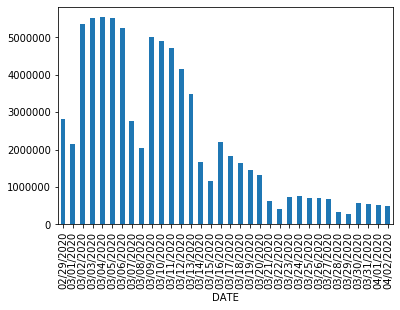

In [52]:
bar1 = all_stations_entries.plot.bar(x='DATE', y=0)
bar1

We can see that in the first week of March, when things were more or less 'normal' in NYC, the subway served more than 5 million riders per weekday. As the pandemic accelerated, we can see a steep decline in daily ridership across the subway system with fewer than 800,000 daily passengers.

Now, let's analyze the ridership trend for the stations that are generally the busiest.

In [102]:
# Calculate the total ridership for the first week of March
daily_entries_by_station['1stWeek'] = daily_entries_by_station['03/02/2020'] \
                                    + daily_entries_by_station['03/03/2020'] \
                                    + daily_entries_by_station['03/04/2020'] \
                                    + daily_entries_by_station['03/05/2020'] \
                                    + daily_entries_by_station['03/06/2020']

# Calculate the weekday average daily ridership
daily_entries_by_station['Weekday Avg'] = daily_entries_by_station['1stWeek'] / 5

# Sort the dataframe by weekday average daily ridership
daily_entries_by_station.sort_values('Weekday Avg', ascending = False, inplace = True)
daily_entries_by_station['Rank'] = daily_entries_by_station['Weekday Avg'].rank(ascending=False).astype(int)

daily_entries_by_station[['Rank','Weekday Avg']][0:10].reset_index()

DATE          STATION  Rank  Weekday Avg
0      34 ST-PENN STA     1     145647.2
1     GRD CNTRL-42 ST     2     130866.2
2               23 ST     3     114271.8
3     34 ST-HERALD SQ     4      94588.4
4           FULTON ST     5      93530.8
5      14 ST-UNION SQ     6      92388.0
6      TIMES SQ-42 ST     7      85688.8
7     42 ST-PORT AUTH     8      82927.8
8               86 ST     9      78394.6
9              125 ST    10      76295.8

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6093EE508>,
      dtype=object)

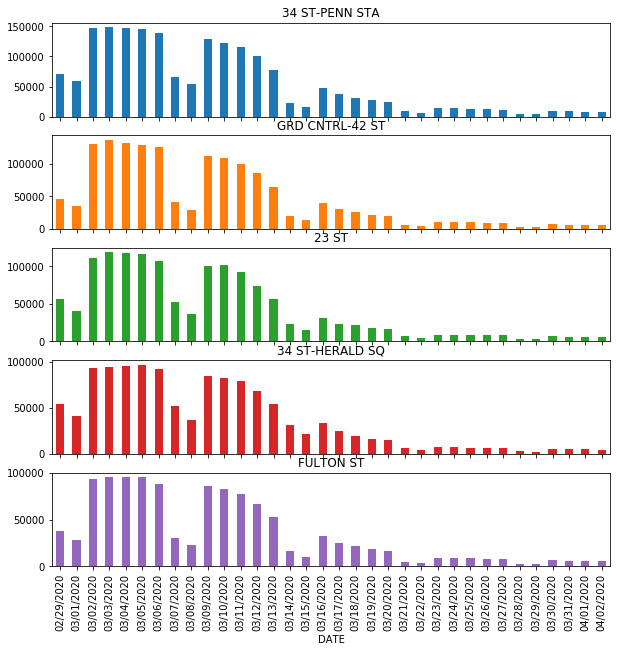

In [83]:
# Let's see the ridership trends for the top five stations

top_five_stations = daily_entries_by_station[daily_entries_by_station['Rank'] <= 5]

top_five_stations.drop(columns=['1stWeek', 'Weekday Avg', 'Rank'], inplace=True)
top_five_stations = top_five_stations.transpose()
top_five_stations.plot.bar(subplots=True, figsize=(10,10), legend=False)

Now, we want to analyze the change in daily entries between the first week of March (starting Monday Mar 2 to Friday Mar 6) and the last week of March (starting Monday Mar 23 to Friday Mar 27). I focused on weekdays because we can see a clear trend that weekday ridership is higher than weekend ridership, and weekday ridership represents how people get to work.

In [ ]:
daily_entries_by_station['LastWeek'] = daily_entries_by_station['03/23/2020'] \
                                    + daily_entries_by_station['03/24/2020'] \
                                    + daily_entries_by_station['03/25/2020'] \
                                    + daily_entries_by_station['03/26/2020'] \
                                    + daily_entries_by_station['03/27/2020']

daily_entries_by_station['PctChg'] = 100 * (daily_entries_by_station['LastWeek'] - daily_entries_by_station['1stWeek']) / daily_entries_by_station['1stWeek']
daily_entries_by_station['AbsChg'] = daily_entries_by_station['LastWeek'] - daily_entries_by_station['1stWeek']

In [118]:
# Sort the dataframe by the absolute change in number of entries to the station
daily_entries_by_station.sort_values('AbsChg', inplace = True)

daily_entries_by_station.head(5)

daily_entries_by_station[['1stWeek','LastWeek','PctChg','AbsChg']][0:10].reset_index()

DATE          STATION   1stWeek  LastWeek     PctChg    AbsChg
0      34 ST-PENN STA  728236.0   64118.0 -91.195437 -664118.0
1     GRD CNTRL-42 ST  654331.0   51610.0 -92.112555 -602721.0
2               23 ST  571359.0   43281.0 -92.424903 -528078.0
3     34 ST-HERALD SQ  472942.0   35025.0 -92.594229 -437917.0
4           FULTON ST  467654.0   43085.0 -90.786992 -424569.0
5      14 ST-UNION SQ  461940.0   46627.0 -89.906265 -415313.0
6      TIMES SQ-42 ST  428444.0   32065.0 -92.515941 -396379.0
7     42 ST-PORT AUTH  414639.0   46386.0 -88.812919 -368253.0
8               86 ST  391973.0   47556.0 -87.867532 -344417.0
9      59 ST COLUMBUS  341180.0   33257.0 -90.252359 -307923.0

The five stations with the largest drop in ridership are also the stations that are generally the busiest.<br><br> Now, we want to analyze what kind of venues are most common around these stations. First let's get the geographical coordinates for these stations.

In [108]:
# Filter the station coordinates dataframe for the top five stations that we obtained from the subway turnstile data
# The naming conventions for the subway stations are different from those in the MTA turnstile dataset 
# So I manually mapped the top stations

top_ten = ['34th St - Penn Station', 'Grand Central - 42nd St', '23rd St', 'Herald Sq - 34th St', 'Fulton St', \
           'Union Sq - 14th St', 'Times Sq - 42nd St', '42nd St - Port Authority Bus Term', '86th St', '59th St - Columbus Circle']

top_ten_coords = station_coords[station_coords['Station'].isin(top_ten)]

top_ten_coords

Station             Line   Latitude  Longitude
30             Grand Central - 42nd St  4-5-6-6 Express  40.751807 -73.976713
79                  Times Sq - 42nd St          N-Q-R-W  40.754612 -73.986768
80             Grand Central - 42nd St                S  40.752769 -73.979189
85                             86th St              1-2  40.788644 -73.976218
91                             23rd St    4-6-6 Express  40.739864 -73.986599
93           59th St - Columbus Circle              1-2  40.768247 -73.981929
95                             23rd St              1-2  40.744081 -73.995657
104                 Union Sq - 14th St  4-5-6-6 Express  40.734673 -73.989951
117                          Fulton St                G  40.687119 -73.975375
144                Herald Sq - 34th St          N-Q-R-W  40.749645 -73.987937
146                 Times Sq - 42nd St                S  40.755983 -73.986229
164                            86th St            A-B-C  40.785823 -73.968828
196                 Times Sq - 42nd St      7-7 Express  40.755477 -73.987691
203            Grand Central - 42nd St      7-7 Express  40.751431 -73.976041
317                            86th St                R  40.622687 -74.028398
352          59th St - Columbus Circle          A-B-C-D  40.768250 -73.981649
357             34th St - Penn Station            1-2-3  40.750373 -73.991057
358                 Times Sq - 42nd St            1-2-3  40.755290 -73.987495
359                          Fulton St              A-C  40.710162 -74.007623
361  42nd St - Port Authority Bus Term            A-C-E  40.757308 -73.989735
364                            23rd St              F-M  40.742954 -73.992765
365                Herald Sq - 34th St          B-D-F-M  40.749789 -73.987772
378                 Union Sq - 14th St          N-Q-R-W  40.735872 -73.990539
379                            23rd St          N-Q-R-W  40.741303 -73.989344
383                 Union Sq - 14th St                L  40.734763 -73.990670
401                          Fulton St              2-3  40.709416 -74.006571
412                          Fulton St              J-Z  40.710023 -74.007938
426                          Fulton St              4-5  40.710368 -74.009509
435                            23rd St            A-C-E  40.745906 -73.998041
436             34th St - Penn Station            A-C-E  40.752287 -73.993391
450                            86th St  4-5-6-6 Express  40.779492 -73.955589
471                            86th St                Q  40.777861 -73.951771

In [109]:
# We can see that there are multiple coordinate pairs for each station depending on the line
# Except for the 23rd St station, these lines are all part of the same station
# We will take the first values for each station

top_ten_coords = top_ten_coords.drop_duplicates(subset ='Station', keep = 'first')

top_ten_coords

Station             Line   Latitude  Longitude
30             Grand Central - 42nd St  4-5-6-6 Express  40.751807 -73.976713
79                  Times Sq - 42nd St          N-Q-R-W  40.754612 -73.986768
85                             86th St              1-2  40.788644 -73.976218
91                             23rd St    4-6-6 Express  40.739864 -73.986599
93           59th St - Columbus Circle              1-2  40.768247 -73.981929
104                 Union Sq - 14th St  4-5-6-6 Express  40.734673 -73.989951
117                          Fulton St                G  40.687119 -73.975375
144                Herald Sq - 34th St          N-Q-R-W  40.749645 -73.987937
357             34th St - Penn Station            1-2-3  40.750373 -73.991057
361  42nd St - Port Authority Bus Term            A-C-E  40.757308 -73.989735

#### Use FourSquare API to explore the area around the stations

In [24]:
# Set FourSquare parameters

#CLIENT_ID =  
#CLIENT_SECRET = 
VERSION = '20180605' # Foursquare API version

In [25]:
# Create function to get nearby venues for a neighborhood

LIMIT = 100 #limit the number of venues returned by FourSquare API

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [110]:
venues = getNearbyVenues(names=top_ten_coords['Station'],
                        latitudes=top_ten_coords['Latitude'],
                        longitudes=top_ten_coords['Longitude']
                        )

Grand Central - 42nd St
Times Sq - 42nd St
86th St
23rd St
59th St - Columbus Circle
Union Sq - 14th St
Fulton St
Herald Sq - 34th St
34th St - Penn Station
42nd St - Port Authority Bus Term


In [111]:
venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Grand Central - 42nd St              40.751807              -73.976713   
1  Grand Central - 42nd St              40.751807              -73.976713   
2  Grand Central - 42nd St              40.751807              -73.976713   
3  Grand Central - 42nd St              40.751807              -73.976713   
4  Grand Central - 42nd St              40.751807              -73.976713   

                      Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Equinox East 44th Street       40.752687       -73.975323             Gym  
1    Num Pang Sandwich Shop       40.750522       -73.976124  Sandwich Place  
2      Grand Central Market       40.752321       -73.976086    Gourmet Shop  
3    Grand Central Terminal       40.752809       -73.977014   Train Station  
4             Meyers Bageri       40.752476       -73.977518  Sandwich Place

In [112]:
# Count the number of venues by venue category
venue_cat = venues.groupby('Venue Category')['Venue'].count()
venue_cat_sorted = venue_cat.sort_values(ascending=False)

venue_cat_sorted.head()

Venue Category
Theater                43
Hotel                  34
Coffee Shop            26
Italian Restaurant     21
Japanese Restaurant    20
Name: Venue, dtype: int64

In [113]:
# The number of venues returned for a neighborhood

venues.groupby('Neighborhood')['Venue'].count()

Neighborhood
23rd St                               98
34th St - Penn Station                71
42nd St - Port Authority Bus Term    100
59th St - Columbus Circle            100
86th St                               52
Fulton St                             77
Grand Central - 42nd St               90
Herald Sq - 34th St                   68
Times Sq - 42nd St                    86
Union Sq - 14th St                    85
Name: Venue, dtype: int64

#### Analyze the venues around a neighborhood

In [114]:
# Create indicator variables for each venue category
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
onehot.head()

Neighborhood  American Restaurant  Arcade  Art Gallery  \
0  Grand Central - 42nd St                    0       0            0   
1  Grand Central - 42nd St                    0       0            0   
2  Grand Central - 42nd St                    0       0            0   
3  Grand Central - 42nd St                    0       0            0   
4  Grand Central - 42nd St                    0       0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Australian Restaurant  \
0           0                    0                 0                      0   
1           0                    0                 0                      0   
2           0                    0                 0                      0   
3           0                    0                 0                      0   
4           0                    0                 0                      0   

   BBQ Joint  Bagel Shop  Bakery  Bar  Baseball Field  Basketball Stadium  \
0          0           0       0    0               0                   0   
1          0           0       0    0               0                   0   
2          0           0       0    0               0                   0   
3          0           0       0    0               0                   0   
4          0           0       0    0               0                   0   

   Bed & Breakfast  Beer Bar  Beer Garden  Bike Rental / Bike Share  \
0                0         0            0                         0   
1                0         0            0                         0   
2                0         0            0                         0   
3                0         0            0                         0   
4                0         0            0                         0   

   Bookstore  Boutique  Boxing Gym  Breakfast Spot  Buffet  Building  \
0          0         0           0               0       0         0   
1          0         0           0               0       0         0   
2          0         0           0               0       0         0   
3          0         0           0               0       0         0   
4          0         0           0               0       0         0   

   Burger Joint  Burrito Place  Café  Cajun / Creole Restaurant  Candy Store  \
0             0              0     0                          0            0   
1             0              0     0                          0            0   
2             0              0     0                          0            0   
3             0              0     0                          0            0   
4             0              0     0                          0            0   

   Caribbean Restaurant  Caucasian Restaurant  Cheese Shop  \
0                     0                     0            0   
1                     0                     0            0   
2                     0                     0            0   
3                     0                     0            0   
4                     0                     0            0   

   Chinese Restaurant  Clothing Store  Cocktail Bar  Coffee Shop  Comedy Club  \
0                   0               0             0            0            0   
1                   0               0             0            0            0   
2                   0               0             0            0            0   
3                   0               0             0            0            0   
4                   0               0             0            0            0   

   Comfort Food Restaurant  Comic Shop  Community Center  Concert Hall  \
0                        0           0                 0             0   
1                        0           0                 0             0   
2                        0           0                 0             0   
3                        0           0                 0             0   
4                        0           0                 0             0  

In [115]:
# Create dataframe with one row for each station and the frequency of appearance of a place category as columns
venues_grouped = onehot.groupby('Neighborhood').mean().reset_index()

venues_grouped.head()

Neighborhood  American Restaurant    Arcade  \
0                            23rd St             0.030612  0.010204   
1             34th St - Penn Station             0.014085  0.000000   
2  42nd St - Port Authority Bus Term             0.010000  0.000000   
3          59th St - Columbus Circle             0.010000  0.000000   
4                            86th St             0.019231  0.000000   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0     0.010204        0.00                 0.00               0.0   
1     0.000000        0.00                 0.00               0.0   
2     0.010000        0.00                 0.02               0.0   
3     0.000000        0.01                 0.00               0.0   
4     0.000000        0.00                 0.00               0.0   

   Australian Restaurant  BBQ Joint  Bagel Shop    Bakery       Bar  \
0                    0.0       0.00    0.020408  0.020408  0.061224   
1                    0.0       0.00    0.000000  0.000000  0.014085   
2                    0.0       0.01    0.000000  0.030000  0.000000   
3                    0.0       0.00    0.000000  0.030000  0.020000   
4                    0.0       0.00    0.038462  0.057692  0.038462   

   Baseball Field  Basketball Stadium  Bed & Breakfast  Beer Bar  Beer Garden  \
0            0.00            0.000000         0.010204  0.010204          0.0   
1            0.00            0.014085         0.000000  0.000000          0.0   
2            0.00            0.000000         0.000000  0.000000          0.0   
3            0.01            0.000000         0.000000  0.000000          0.0   
4            0.00            0.000000         0.000000  0.000000          0.0   

   Bike Rental / Bike Share  Bookstore  Boutique  Boxing Gym  Breakfast Spot  \
0                      0.00   0.010204       0.0    0.000000        0.000000   
1                      0.00   0.000000       0.0    0.014085        0.000000   
2                      0.00   0.010000       0.0    0.000000        0.000000   
3                      0.01   0.000000       0.0    0.000000        0.000000   
4                      0.00   0.019231       0.0    0.000000        0.019231   

   Buffet  Building  Burger Joint  Burrito Place      Café  \
0    0.00  0.000000      0.010204           0.00  0.020408   
1    0.00  0.014085      0.042254           0.00  0.014085   
2    0.00  0.000000      0.020000           0.00  0.000000   
3    0.01  0.010000      0.010000           0.01  0.010000   
4    0.00  0.000000      0.000000           0.00  0.000000   

   Cajun / Creole Restaurant  Candy Store  Caribbean Restaurant  \
0                        0.0         0.00                   0.0   
1                        0.0         0.00                   0.0   
2                        0.0         0.00                   0.0   
3                        0.0         0.01                   0.0   
4                        0.0         0.00                   0.0   

   Caucasian Restaurant  Cheese Shop  Chinese Restaurant  Clothing Store  \
0                  0.00     0.020408            0.010204        0.000000   
1                  0.00     0.000000            0.014085        0.014085   
2                  0.01     0.000000            0.000000        0.000000   
3                  0.00     0.000000            0.000000        0.010000   
4                  0.00     0.000000            0.019231        0.000000   

   Cocktail Bar  Coffee Shop  Comedy Club  Comfort Food Restaurant  \
0      0.010204     0.020408     0.010204                     0.00   
1      0.000000     0.028169     0.000000                     0.00   
2      0.010000     0.040000     0.000000                     0.01   
3      0.010000     0.020000     0.000000                     0.00   
4      0.000000     0.038462     0.000000                     0.00   

   Comic Shop  Community Center  Concert Hall  Cosmetics Shop  Creperie  \
0        0.00              0.00          0.00        0.051

In [119]:
venues_grouped.sum(axis=1)

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
dtype: float64

In [116]:
# Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [117]:
# Create a new dataframe with the neighborhoods as rows and the 1st to 10th most common venues as columns
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

# Fill the dataframe out with the ten most common venues
for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = \
    return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood 1st Most Common Venue  \
0                            23rd St     Indian Restaurant   
1             34th St - Penn Station     Korean Restaurant   
2  42nd St - Port Authority Bus Term               Theater   
3          59th St - Columbus Circle          Concert Hall   
4                            86th St    Italian Restaurant   
5                          Fulton St    Italian Restaurant   
6            Grand Central - 42nd St        Sandwich Place   
7                Herald Sq - 34th St     Korean Restaurant   
8                 Times Sq - 42nd St               Theater   
9                 Union Sq - 14th St   American Restaurant   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                   Bar        Cosmetics Shop             Wine Shop   
1           Music Venue                 Hotel            Donut Shop   
2                 Hotel    Italian Restaurant           Coffee Shop   
3                   Gym             Jazz Club               Theater   
4           Pizza Place                Bakery            Bagel Shop   
5           Coffee Shop                Lounge        Cosmetics Shop   
6                 Hotel           Coffee Shop   Japanese Restaurant   
7                 Hotel          Burger Joint   Japanese Restaurant   
8                 Hotel                Bakery          Burger Joint   
9                  Café        Ice Cream Shop                  Park   

  5th Most Common Venue 6th Most Common Venue          7th Most Common Venue  \
0   American Restaurant   Japanese Restaurant        New American Restaurant   
1          Burger Joint                   Pub                  Deli / Bodega   
2        Sandwich Place                Bakery         Furniture / Home Store   
3                   Spa             Juice Bar                         Bakery   
4                   Gym       Thai Restaurant  Vegetarian / Vegan Restaurant   
5           Flower Shop          Burger Joint          Performing Arts Venue   
6         Deli / Bodega        Clothing Store                  Grocery Store   
7          Dessert Shop             Hotel Bar           Gym / Fitness Center   
8          Cycle Studio             Bookstore               Cuban Restaurant   
9        Cosmetics Shop  Gym / Fitness Center                      Bookstore   

     8th Most Common Venue 9th Most Common Venue    10th Most Common Venue  
0              Cheese Shop           Coffee Shop                      Café  
1     Fast Food Restaurant                Lounge          Sushi Restaurant  
2       Seafood Restaurant  Gym / Fitness Center                       Gym  
3                    Hotel         Grocery Store         French Restaurant  
4              Coffee Shop                   Bar              Dessert Shop  
5              Opera House               Theater                Playground  
6       Salon / Barbershop          Liquor Store                Steakhouse  
7  New American Restaurant            Donut Shop            Cosmetics Shop  
8                    Plaza         Deli / Bodega       Japanese Restaurant  
9      Japanese Restaurant    Mexican Restaurant  Mediterranean Restaurant

### Results and Discussion

New Yorkers have to rely on the subway system to get to most places. Usage of the NYC subway system has dramatically decreased throughout March 2020, on a system-wide basis as well as at the station level for the top five busiest stations. The use of the subway system is now only for essential workers who still depend on it to get to their workplaces. The decline in passengers and revenue will cause significant financial burden for the MTA. Even after NYC recovers from the immediate crisis, people would be wary of being in enclosed spaces with multiple passengers for a prolonged period of time potentially in crowded conditions. Therefore, subway ridership is not expected to recover to pre-COVID-19 levels anytime soon.

We also see that stations that experience the largest drop in entries are in Manhattan. Half of them (the 34th street stations and the 42nd street stations) are in midtown, which has plenty of offices with the jobs that allow remote work. The most common venues around these subway stations include cafes and restaurants, places for tourists such as hotels and theaters, as well as places that cater more to locals such as gyms and fitness studios. Around 34th street Koreatown, we see that Korean restaurants are the most popular. Around the 42nd street stations, theaters are the most popular since this is where the broadway theaters are. All these businesses would experience a significant decline in customers as reflected in the decline in usage of the subway stations which provide access to these businesses.


### Conclusion

The analysis shows that the NYC subway transit system serves a large number of passengers, with more than 5 million daily riders on weekdays during regular times. As the COVID-19 pandemic became more severe, there has been a steep decline in ridership of the subway, with weekday ridership falling by more than 90% across the system.

For the top five subway stations that experienced the largest absolute drop in number of entries in March 2020, the surrounding neighborhoods largely consist of cafes, restaurants and bars, as well as fitness studios and gyms. We can also see that hotels and theaters are in the top 10 venues for half of the neighborhoods. From these results, we can expect that the travel and entertainment, restaurants and fitness industries are going to be the economically hardest hit industries in NYC. Government support will be needed to keep the local businesses in these industries alive.
